<a href="https://colab.research.google.com/github/MehakArora/ImageInpainting/blob/main/Partial_Convolutions_Tr4_NDataset_NMetrics_Tr2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MehakArora/ImageInpainting.git
%cd ImageInpainting

Cloning into 'ImageInpainting'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 68 (delta 26), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (68/68), done.
/content/ImageInpainting


In [2]:
!pip install tensorflow-gpu==2.0

     |████████████████████████████████| 380.8 MB 41 kB/s 
     |████████████████████████████████| 449 kB 43.8 MB/s 
     |████████████████████████████████| 3.8 MB 40.5 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=3f3d5a29ebc1ed2f3bca07a913e900049466877d2c2806394d4e09ec26f987f9
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [3]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.python.client import device_lib
#from pconv_layer import PConv2D

from utils.pconv_layer import PConv2D

import cv2
print(cv2.__version__)
from skimage.metrics import structural_similarity as SSIM
from mpl_toolkits.axes_grid1 import ImageGrid

print('[INFO]', tf.config.experimental.list_physical_devices('GPU')[0])

2.0.0
4.1.2
[INFO] PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

In [5]:
## Intel dataset
import os
import cv2
print(cv2.__version__)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from skimage.metrics import structural_similarity as SSIM

from mpl_toolkits.axes_grid1 import ImageGrid

4.1.2


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/drive/MyDrive/ECE_6254/archive(1).zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
seg_train/seg_train/mountain/7539.jpg          2019-10-18 05:52:02        16948
seg_train/seg_train/mountain/7551.jpg          2019-10-18 05:52:02         8318
seg_train/seg_train/mountain/7560.jpg          2019-10-18 05:52:02         8029
seg_train/seg_train/mountain/7565.jpg          2019-10-18 05:52:02        10892
seg_train/seg_train/mountain/7578.jpg          2019-10-18 05:52:02        11674
seg_train/seg_train/mountain/7581.jpg          2019-10-18 05:52:02        14910
seg_train/seg_train/mountain/7586.jpg          2019-10-18 05:52:02         6908
seg_train/seg_train/mountain/7647.jpg          2019-10-18 05:52:02        20167
seg_train/seg_train/mountain/7652.jpg          2019-10-18 05:52:02        11952
seg_train/seg_train/mountain/7654.jpg          2019-10-18 05:52:02        11998
seg_train/seg_train/mountain/7662.jpg          2019-10-18 05:52:02         7367
seg_train/seg_train/mountain/767.jpg           2019-10-18 05:52:02   

In [8]:
"Getting File Names"

#Train Data
train_path = './seg_train/seg_train/'
train_folders = os.listdir(train_path)
train_files = []

for folder in train_folders:
    files_f = os.listdir(train_path + folder + '/')
    for file in files_f:
        train_files.append(train_path + folder + '/' + file)
        
#Val Data
val_path = './seg_test/seg_test/'
val_folders = os.listdir(val_path)
val_files = []

for folder in val_folders:
    files_f = os.listdir(val_path + folder + '/')
    for file in files_f:
        val_files.append(val_path + folder + '/' + file)
  
#Testing Data
pred_path = './seg_pred/seg_pred/'
pred_files = []


for file in os.listdir(pred_path):
    pred_files.append(pred_path + file)

In [9]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(64, 64), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # Masked_images is a matrix of masked images used as input
    Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # Mask_batch is a matrix of binary masks used as input
    Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image
    

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image, mask = self.__createMask(image_copy)
      
      Masked_images[i,] = masked_image/255
      Mask_batch[i,] = mask/255
      y_batch[i] = self.y[idx]/255

    ## Return mask as well because partial convolution require the same.
    return [Masked_images, Mask_batch], y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((64,64,3), 255, np.uint8) ## White background
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 3)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)

    ### Mask the image
    #masked_image = img.copy()
    #masked_image[mask==0] = 255

    # Perforn bitwise and operation to mak the image
    try:
      masked_image = cv2.bitwise_and(img, mask)

    except:
      print("Img.shape: ", img.shape)
      print("Mask.shape: ",mask.shape)

    return masked_image, mask

In [10]:
import cv2

x_train = []
for file_path in train_files:
  img = cv2.imread(file_path)
  resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  x_train.append(resized)
  
x_train = np.array(x_train)


x_val = []
for file_path in val_files:
  img = cv2.imread(file_path)
  resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  x_val.append(resized)
  
x_val = np.array(x_val)

x_pred = []
for file_path in pred_files:
  img = cv2.imread(file_path)
  resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  x_pred.append(resized)
  
x_pred = np.array(x_pred)

(64, 64, 3)


(14034, 64, 64, 3)

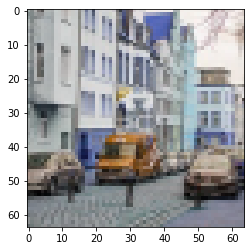

In [11]:
img = x_pred[0]
#resized = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
#plt.imshow(img)
print(img.shape)
plt.imshow(img)
x_train.shape

In [12]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_val, x_val, shuffle=False)

In [13]:
len(traingen)

438

# Partial Convolutions


For tasks like image segmentation, image inpainting etc, pixel-wise accuracy is not a good metric because of high color class imbalance. Though it’s easy to interpret, the accuracy score is often misleading. Two commonly used alternatives are IoU (Intersection over Union) and Dice Coefficient. They are both similar, in the sense that the goal is to maximize the area of overlap between the predicted pixel and the ground truth pixel divided by their union.

In [42]:
def dice_coef(y_true, y_pred):
   y_true_f = keras.backend.flatten(y_true)
   y_pred_f = keras.backend.flatten(y_pred)
   intersection = keras.backend.sum(y_true_f * y_pred_f)
   return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

def get_psnr(y_true, y_pred):
  val = tf.image.psnr(y_true, y_pred, 1)
  return val
  
#def get_ssim(y_true, y_pred):
#  val = None
#  try:
#    if(y_true.shape[1] == 8):
#      val = 0
#    else:
#      val = tf.image.ssim(y_true, y_pred, 1)
#  except:
#    pass
#  return val

def get_ssim(y_true, y_pred):
  y_true_tensor = tf.image.convert_image_dtype(y_true, tf.float32)
  y_pred_tensor = tf.image.convert_image_dtype(y_pred, tf.float32)
  val = tf.image.ssim(y_true_tensor, y_pred_tensor, 1)
  return float(val)

#ssim_test = get_ssim(sample_labels[0],impainted_image.reshape(impainted_image.shape[1:]))
#print(ssim_test)

In [16]:
class InpaintingModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(64,64,3)):
    input_image = keras.layers.Input(input_size)
    input_mask = keras.layers.Input(input_size, name='encoder_input')
  
    conv1, mask1, conv2, mask2 = self.__encoder_layer(64, input_image, input_mask, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6, ['conv7', 'encoder_output'])

    conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])

    
    outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

    return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])
    
  def __encoder_layer(self, filters, in_layer, in_mask, names):
    conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2, training=True)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

  def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
    concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

    conv1, mask1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mask])
    conv1 = keras.activations.relu(conv1)

    conv2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv1, mask1])
    # conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.activations.relu(conv2)

    return conv1, mask1, conv2, mask2

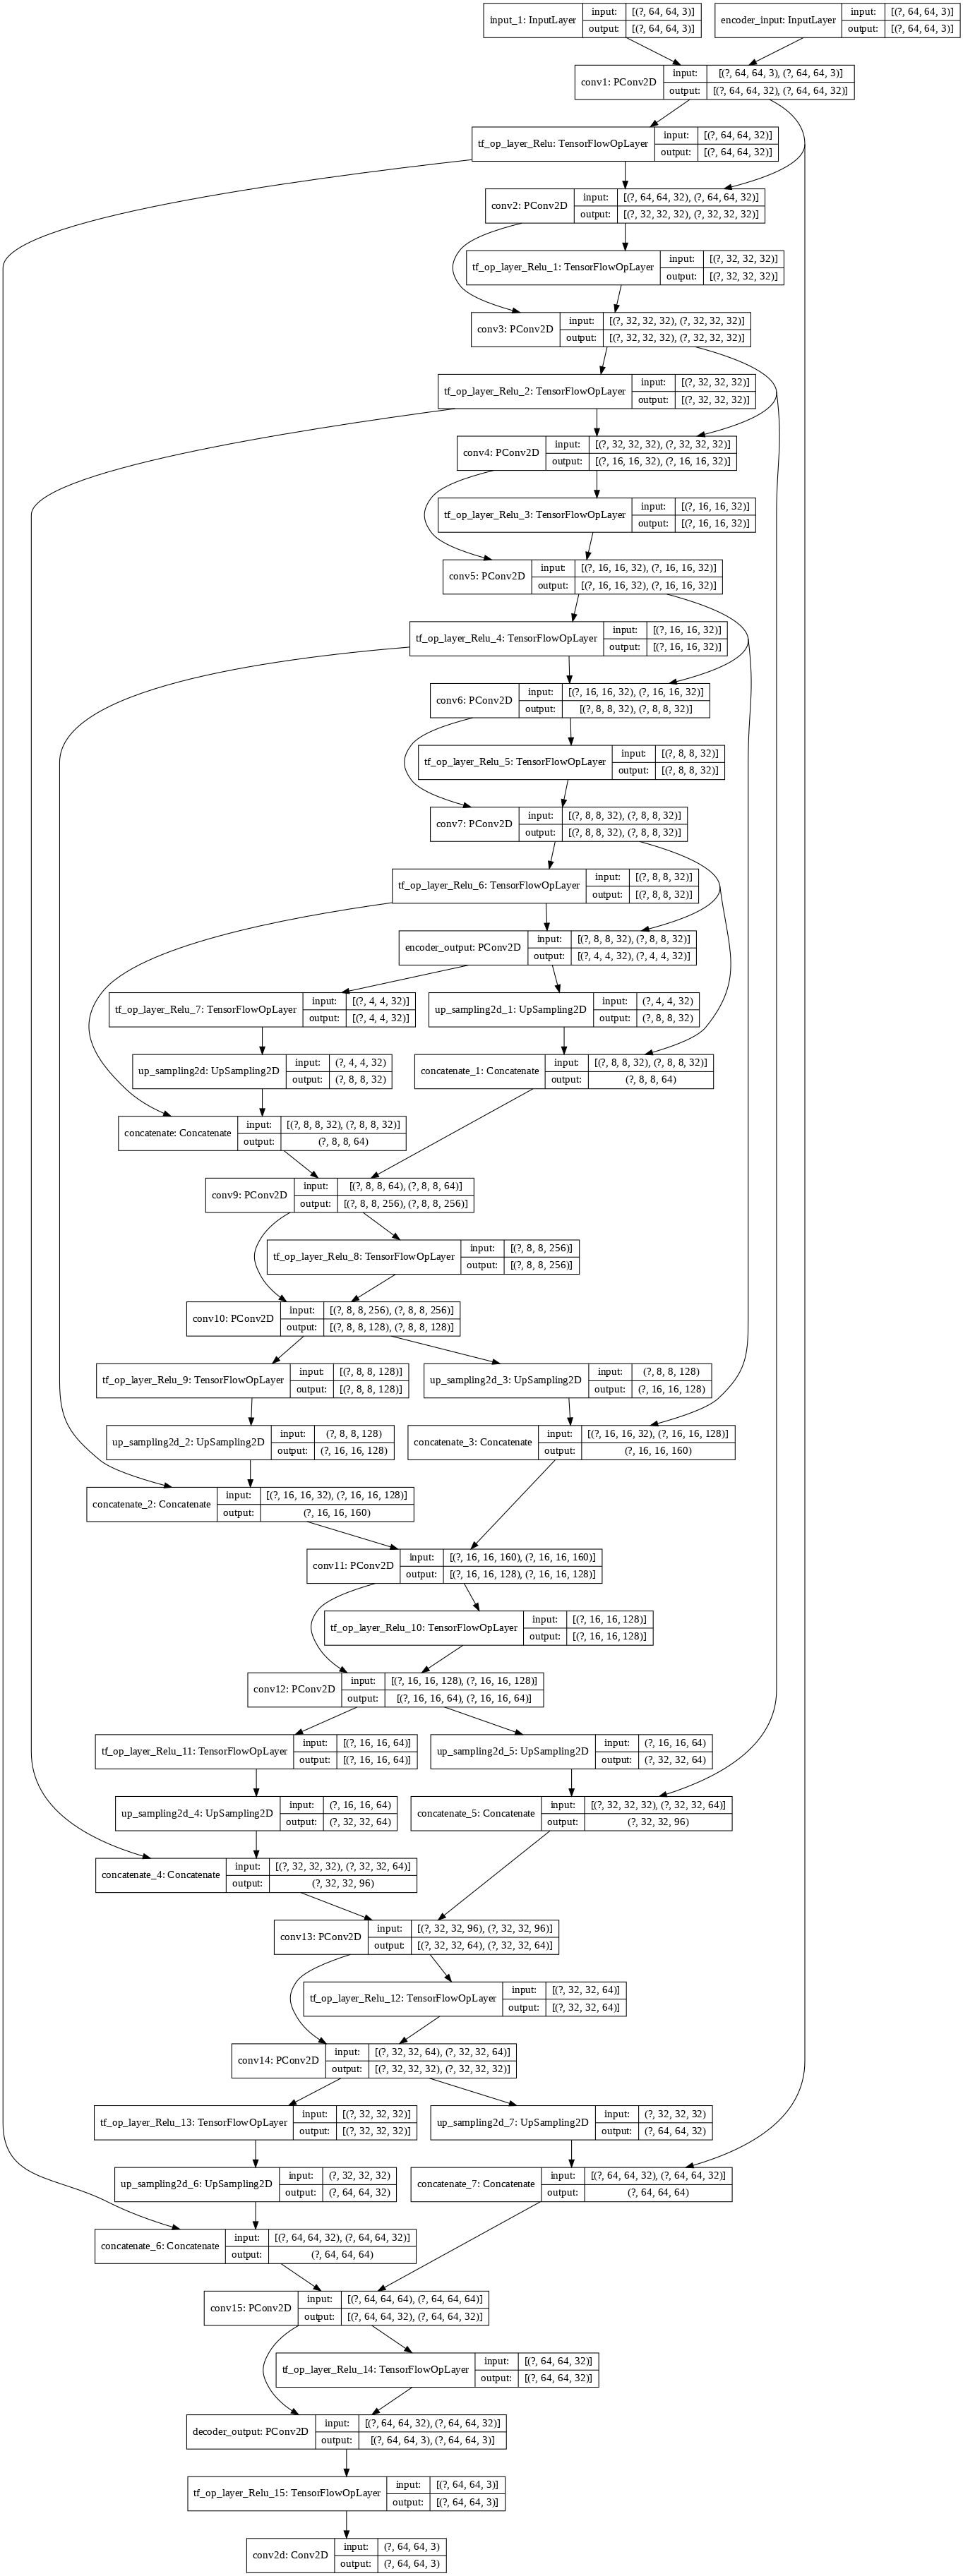

In [17]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
# model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v3.png')

In [18]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    def on_epoch_end(self, logs, epoch):
        sample_idx = 54
        [masked_images, masks], sample_labels = testgen[sample_idx]  
        
        m_images = []
        binary_masks = []
        predictions = []
        labels = []
        
        for i in range(32):
          inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
          impainted_image = model.predict(inputs)

          m_images.append(masked_images[i])
          binary_masks.append(masks[i])
          predictions.append(impainted_image.reshape(impainted_image.shape[1:]))
          labels.append(sample_labels[i])

        #wandb.log({"masked_images": [wandb.Image(m_image)
         #                     for m_image in m_images]})
        #wandb.log({"masks": [wandb.Image(mask)
         #                     for mask in binary_masks]})
        #wandb.log({"predictions": [wandb.Image(inpainted_image)
         #                     for inpainted_image in predictions]})
        #wandb.log({"labels": [wandb.Image(label)
         #                     for label in labels]})

In [19]:
_ = model.fit_generator(traingen, validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True,)
          #callbacks=[PredictionLogger()])

Epoch 1/20
438/438 [==============================] - 143s 327ms/step - loss: 0.1357 - dice_coef: 0.5234 - val_loss: 0.0813 - val_dice_coef: 0.5606
Epoch 2/20
438/438 [==============================] - 140s 319ms/step - loss: 0.0777 - dice_coef: 0.5741 - val_loss: 0.0747 - val_dice_coef: 0.5656
Epoch 3/20
438/438 [==============================] - 140s 319ms/step - loss: 0.0740 - dice_coef: 0.5761 - val_loss: 0.0721 - val_dice_coef: 0.5685
Epoch 4/20
438/438 [==============================] - 141s 321ms/step - loss: 0.0716 - dice_coef: 0.5773 - val_loss: 0.0696 - val_dice_coef: 0.5689
Epoch 5/20
438/438 [==============================] - 140s 320ms/step - loss: 0.0685 - dice_coef: 0.5793 - val_loss: 0.0663 - val_dice_coef: 0.5717
Epoch 6/20
438/438 [==============================] - 140s 320ms/step - loss: 0.0658 - dice_coef: 0.5809 - val_loss: 0.0639 - val_dice_coef: 0.5724
Epoch 7/20
438/438 [==============================] - 140s 320ms/step - loss: 0.0634 - dice_coef: 0.5823 - val_l

Image (1): PSNR = 27.684841, SSIM = 0.943022
Image (2): PSNR = 24.909422, SSIM = 0.942254
Image (3): PSNR = 27.191000, SSIM = 0.895998
Image (4): PSNR = 26.530909, SSIM = 0.954661
Image (5): PSNR = 27.899515, SSIM = 0.931002
Image (6): PSNR = 27.581053, SSIM = 0.958394
Image (7): PSNR = 33.417431, SSIM = 0.942747
Image (8): PSNR = 29.234159, SSIM = 0.934702
Image (9): PSNR = 32.307240, SSIM = 0.903183
Image (10): PSNR = 31.777189, SSIM = 0.906003
Image (11): PSNR = 29.900425, SSIM = 0.955094
Image (12): PSNR = 23.237757, SSIM = 0.807697
Image (13): PSNR = 30.284931, SSIM = 0.956123
Image (14): PSNR = 30.210217, SSIM = 0.965048
Image (15): PSNR = 27.646879, SSIM = 0.861423
Image (16): PSNR = 26.012009, SSIM = 0.908889
Image (17): PSNR = 26.691439, SSIM = 0.870762
Image (18): PSNR = 27.338255, SSIM = 0.920583
Image (19): PSNR = 25.902685, SSIM = 0.882193
Image (20): PSNR = 33.538483, SSIM = 0.954887
Image (21): PSNR = 28.435228, SSIM = 0.949782
Image (22): PSNR = 24.934851, SSIM = 0.8593

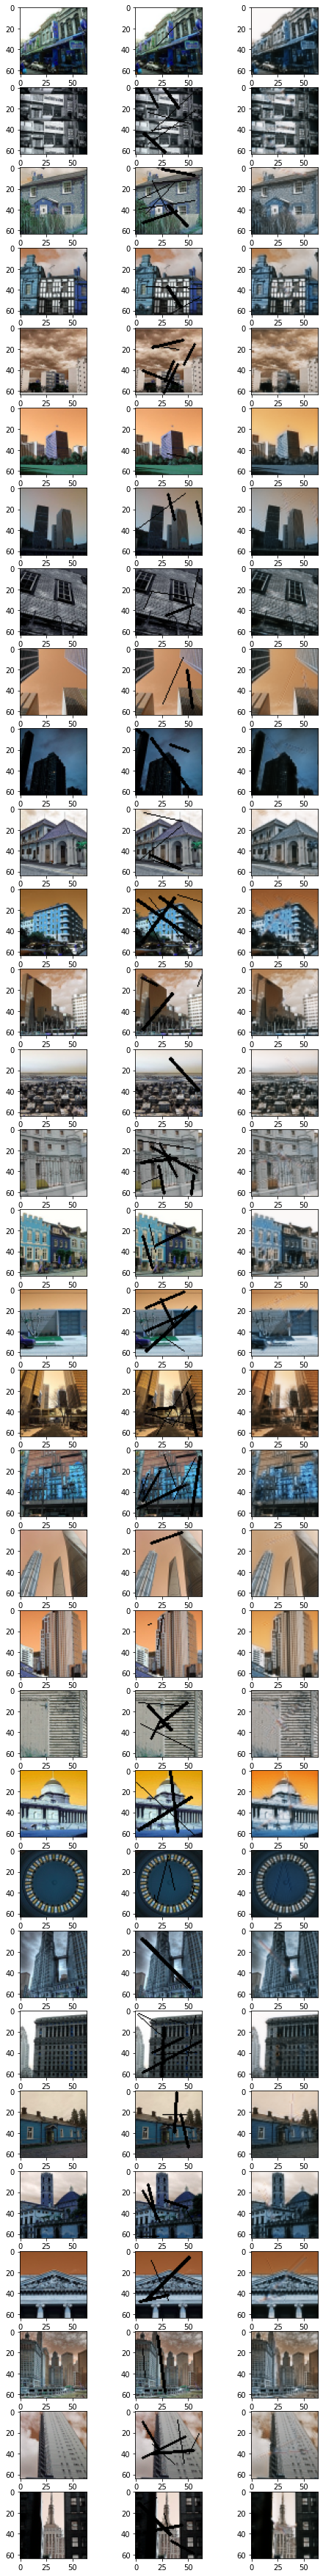

In [44]:
## Legend: Original Image | Mask generated | Inpainted Image | Ground Truth
from skimage.metrics import structural_similarity as SSIM
## Examples
rows = 32
sample_idx = 70
[masked_images, masks], sample_labels = testgen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(8, 2*rows))

for i in range(32):
  inputs = [masked_images[i].reshape((1,)+masked_images[i].shape), masks[i].reshape((1,)+masks[i].shape)]
  impainted_image = model.predict(inputs)

  ## Metrics old
  #img_orig_gray = cv2.cvtColor(sample_labels[i].astype('uint8'),cv2.COLOR_BGR2GRAY)
  #img_inpainted_gray = cv2.cvtColor(impainted_image.reshape(impainted_image.shape[1:]).astype('uint8'),cv2.COLOR_BGR2GRAY)
  #PSNR_val = cv2.PSNR(img_orig_gray, img_inpainted_gray, 255)
  ##print(PSNR)
  ##SSIM_val = SSIM(sample_labels[i], impainted_image.reshape(impainted_image.shape[1:]),multichannel=True)
  #SSIM_val = SSIM(img_orig_gray, img_inpainted_gray,multichannel=True)

  # Metrics new
  PSNR_val = get_psnr(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]).astype('float64'))
  SSIM_val = get_ssim(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]))
  print("Image (%i): PSNR = %f, SSIM = %f"%(i+1,PSNR_val,SSIM_val))

  # Plotting:
  axs[i][0].imshow(sample_labels[i])                                              # Ground truth
  axs[i][1].imshow(masked_images[i])                                              # Masked image
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))            # Inpainted image
  #axs[i][0].set_xlabel('PSNR : ' + str(PSNR_val) + '\nSSIM: ' + str(SSIM_val))
  
  #axs[i][0].imshow(masked_images[i])
  #axs[i][1].imshow(masks[i])
  #axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  ##print(impainted_image.shape[1:])
  #axs[i][3].imshow(sample_labels[i])
  ##print(sample_labels[i])
  
plt.show()
fig.savefig("test2.png",dpi=600)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save("./drive/MyDrive/GA_Tech/Sp_2022_ECE_6254/my_model_part_conv2")